In [4]:
# ------------------------------------
# Run the mass balance calibration
# ------------------------------------
# Following the OGGM documentation, using
# the HISTALP climate data set.
# https://oggm.readthedocs.io/en/latest/run_examples/run_mb_calibration.html
# ------------------------------------

# Python imports
from os import path

# Libs
import numpy as np

# Locals
import oggm
from oggm import cfg, utils, tasks, workflow
from oggm.workflow import execute_entity_task

# Module logger
import logging
log = logging.getLogger(__name__)

# RGI Version
rgi_version = '61'
rgi_region = '11'

# Initialize OGGM and set up the run parameters
cfg.initialize()

# Local paths (where to write the OGGM run output)
wdir = 'mb_calib_wd'
utils.mkdir(wdir, reset=True)
cfg.PATHS['working_dir'] = wdir

# We are running the calibration ourselves
cfg.PARAMS['run_mb_calibration'] = True

# No need for intersects since this has an effect on the inversion only
cfg.PARAMS['use_intersects'] = False

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = True

# Set to True for operational runs
cfg.PARAMS['continue_on_error'] = False

# This used to be true but will change soon
cfg.PARAMS['filter_for_neg_flux'] = False

cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_all_liq'] = 2.0
cfg.PARAMS['temp_melt'] = -1.75
cfg.PARAMS['temp_default_gradient'] = -0.0065

# Set path to Histalp
cfg.PATHS['climate_file'] = 'raw_data/histalp_merged_full.nc'

2018-08-02 16:08:33: oggm.cfg: Parameter file: /home/mowglie/Documents/git/oggm-fork/oggm/params.cfg


In [5]:
# Get the reference glacier ids (they are different for each RGI version)
df, _ = utils.get_wgms_files()
rids = df['RGI{}0_ID'.format(rgi_version[0])]

# subset for central europe (RGI region 11)
rids = [rid for rid in rids if '-{}.'.format(rgi_region) in rid]

# remove glaciers that caused problems in prior runs 
# (not in the Alps)
rids_to_delete = ['RGI60-11.03232', 'RGI60-11.03209', 'RGI60-11.03241']
for rids_tmp in rids_to_delete:
    rids.remove(rids_tmp)

# Make a new DataFrame with those (this takes a while)
log.info('Reading the RGI shape files...')
rgidf = utils.get_rgi_glacier_entities(rids, version=rgi_version)


# We have to check which of them actually have enough mb data.
# Let OGGM do it: first create GlacierDirectories
gdirs = workflow.init_glacier_regions(rgidf)
# We need to know which period we have data for
log.info('Process the climate data...')
execute_entity_task(tasks.process_custom_climate_data, gdirs, print_log=True)
gdirs = utils.get_ref_mb_glaciers(gdirs)
# Keep only these
rgidf = rgidf.loc[rgidf.RGIId.isin([g.rgi_id for g in gdirs])]

# Save
log.info('For RGIV{} we have {} reference glaciers.'.format(rgi_version,
                                                            len(rgidf)))
rgidf.to_file(path.join(wdir, 'mb_ref_glaciers.shp'))

2018-08-02 16:08:35: __main__: Reading the RGI shape files...
2018-08-02 16:08:36: oggm.workflow: Multiprocessing: using all available processors (N=8)
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00012) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00002) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00073) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00190) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00080) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00289) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00251) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00106) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00603) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00300) define_glacier_region
2018-08-02 16:08:36: oggm.core.gis: (RGI60-11.00619) define_glacier_region
2018-08-02 16:08:36: og

In [6]:
# Sort for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)

# Go - initialize working directories
gdirs = workflow.init_glacier_regions(rgidf)

# Prepro tasks
task_list = [
    tasks.glacier_masks,
    tasks.compute_centerlines,
    tasks.initialize_flowlines,
    tasks.catchment_area,
    tasks.catchment_intersections,
    tasks.catchment_width_geom,
    tasks.catchment_width_correction,
]
# execute all tasks
for task in task_list:
    execute_entity_task(task, gdirs)

# Climate tasks
execute_entity_task(tasks.process_custom_climate_data, gdirs)
tasks.compute_ref_t_stars(gdirs)

2018-08-02 16:09:21: oggm.core.climate: Compute the reference t* and mu* for WGMS glaciers
2018-08-02 16:09:22: oggm.core.climate: (RGI60-11.01450) mu_candidates
2018-08-02 16:09:22: oggm.core.climate: (RGI60-11.03643) mu_candidates
2018-08-02 16:09:22: oggm.core.climate: (RGI60-11.00106) mu_candidates
2018-08-02 16:09:22: oggm.core.climate: (RGI60-11.02766) mu_candidates
2018-08-02 16:09:22: oggm.core.climate: (RGI60-11.01238) mu_candidates
2018-08-02 16:09:22: oggm.core.climate: (RGI60-11.02773) mu_candidates
2018-08-02 16:09:22: oggm.core.climate: (RGI60-11.03638) mu_candidates
2018-08-02 16:09:22: oggm.core.climate: (RGI60-11.02704) mu_candidates
2018-08-02 16:09:23: oggm.core.climate: (RGI60-11.00719) mu_candidates
2018-08-02 16:09:23: oggm.core.climate: (RGI60-11.00897) mu_candidates
2018-08-02 16:09:23: oggm.core.climate: (RGI60-11.02072) mu_candidates
2018-08-02 16:09:23: oggm.core.climate: (RGI60-11.02245) mu_candidates
2018-08-02 16:09:23: oggm.core.climate: (RGI60-11.02774) 

In [9]:
gdr = [gd for gd in gdirs if gd.rgi_id == 'RGI60-11.01238'][0]
gdr

<oggm.GlacierDirectory>
  RGI id: RGI60-11.01238
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Name: Rhone
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 15.837 km2
  Lon, Lat: (8.3965, 46.6236)
  Grid (nx, ny): (100, 165)
  Grid (dx, dy): (66.0, -66.0)

In [10]:
gda = [gd for gd in gdirs if gd.rgi_id == 'RGI60-11.01450'][0]
gda

<oggm.GlacierDirectory>
  RGI id: RGI60-11.01450
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 82.206 km2
  Lon, Lat: (8.01919, 46.5028)
  Grid (nx, ny): (127, 174)
  Grid (dx, dy): (137.0, -137.0)

In [12]:
mbr = gdr.get_ref_mb_data()
mba = gda.get_ref_mb_data()

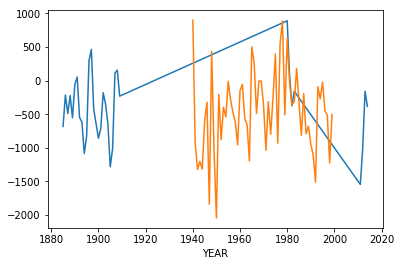

In [14]:
ax = mbr['ANNUAL_BALANCE'].plot()
mba['ANNUAL_BALANCE'].plot(ax=ax)